<a href="https://colab.research.google.com/github/jlifferth/UQ-BIO-2021/blob/main/uqbio2021_SSA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Instructor: Lisa Weber
Author: Lisa Weber
Contact Info: llweber@rams.colostate.edu
 
Copyright (c) 2021 Dr. Brian Munsky. 
Dr. Luis Aguilera, Will Raymond
Colorado State University.
Licensed under MIT License.
```

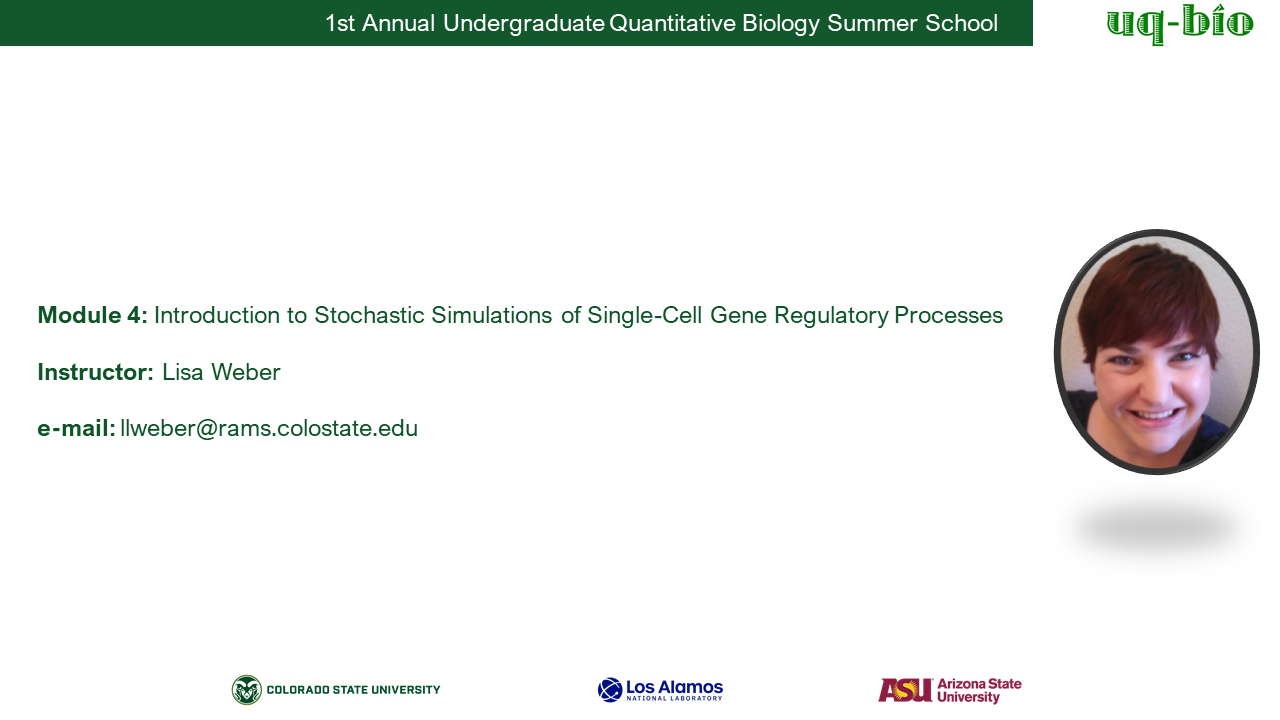

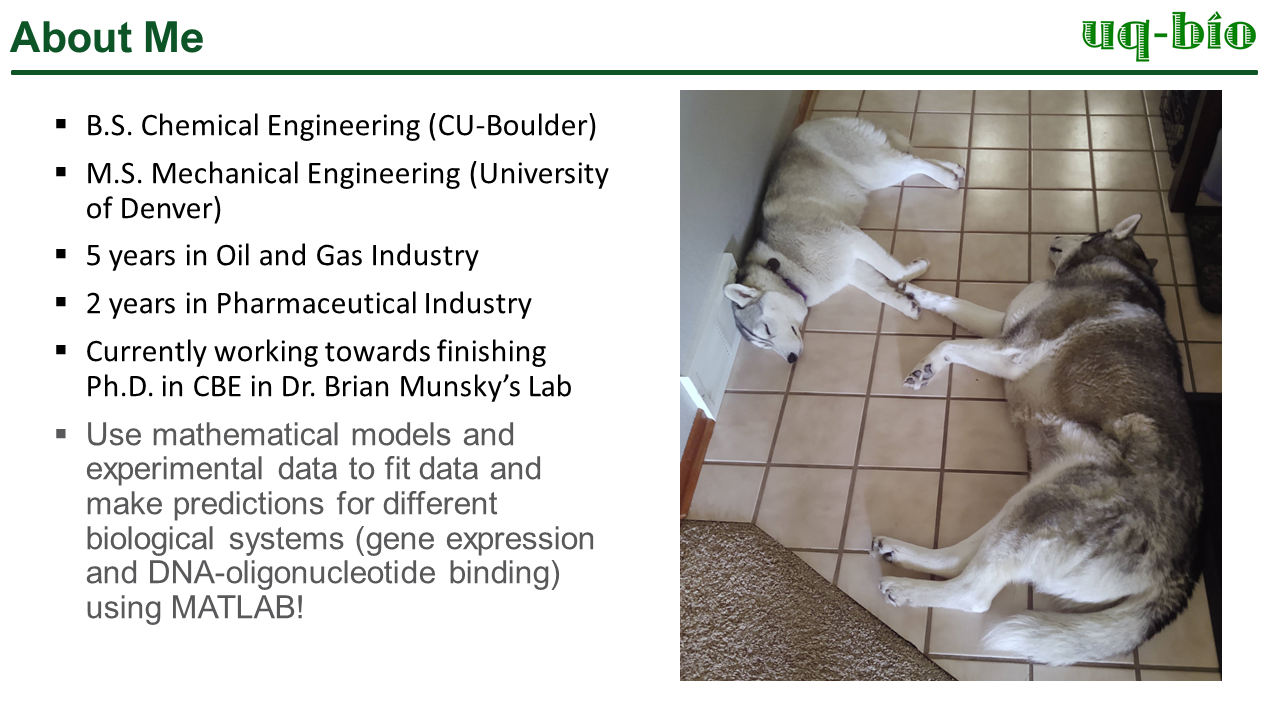

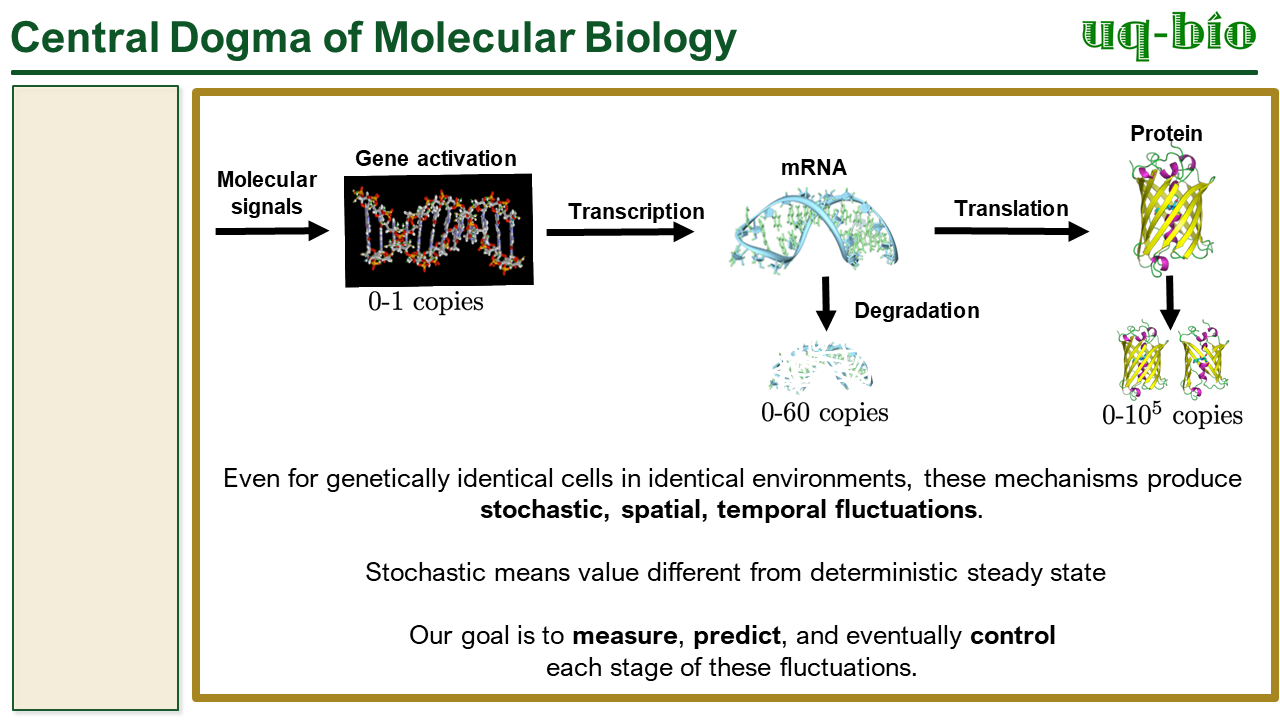

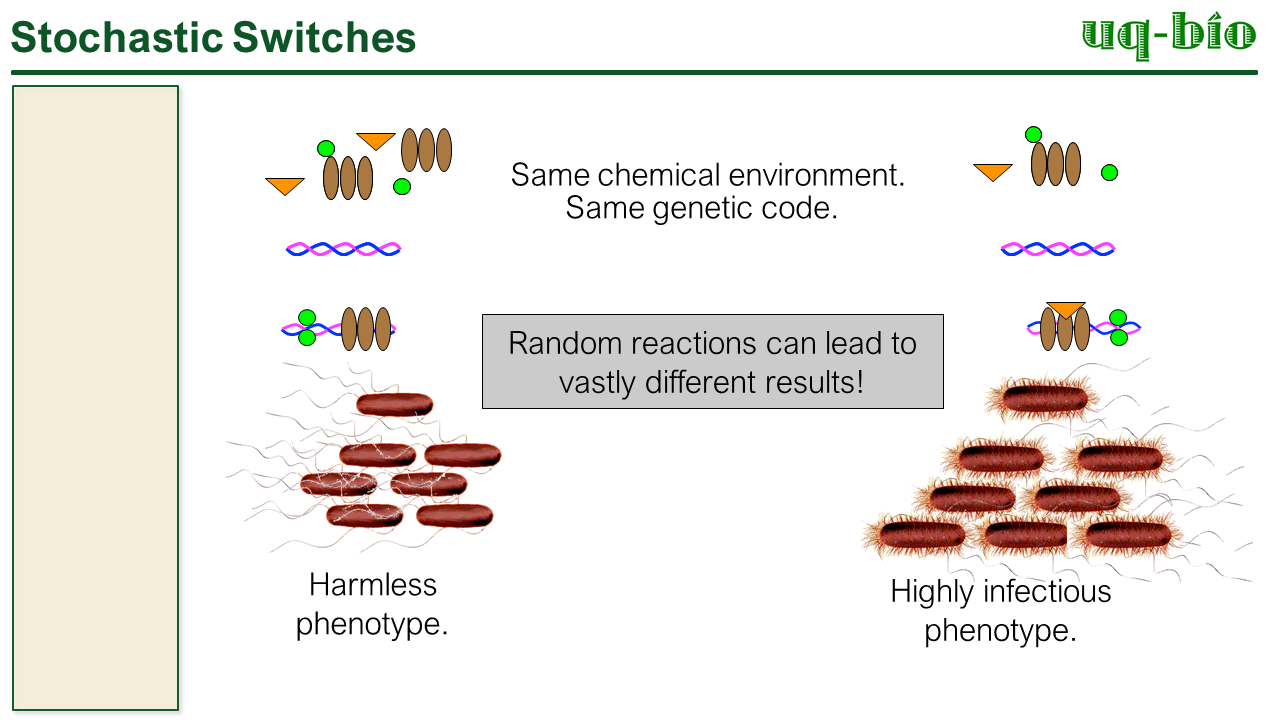

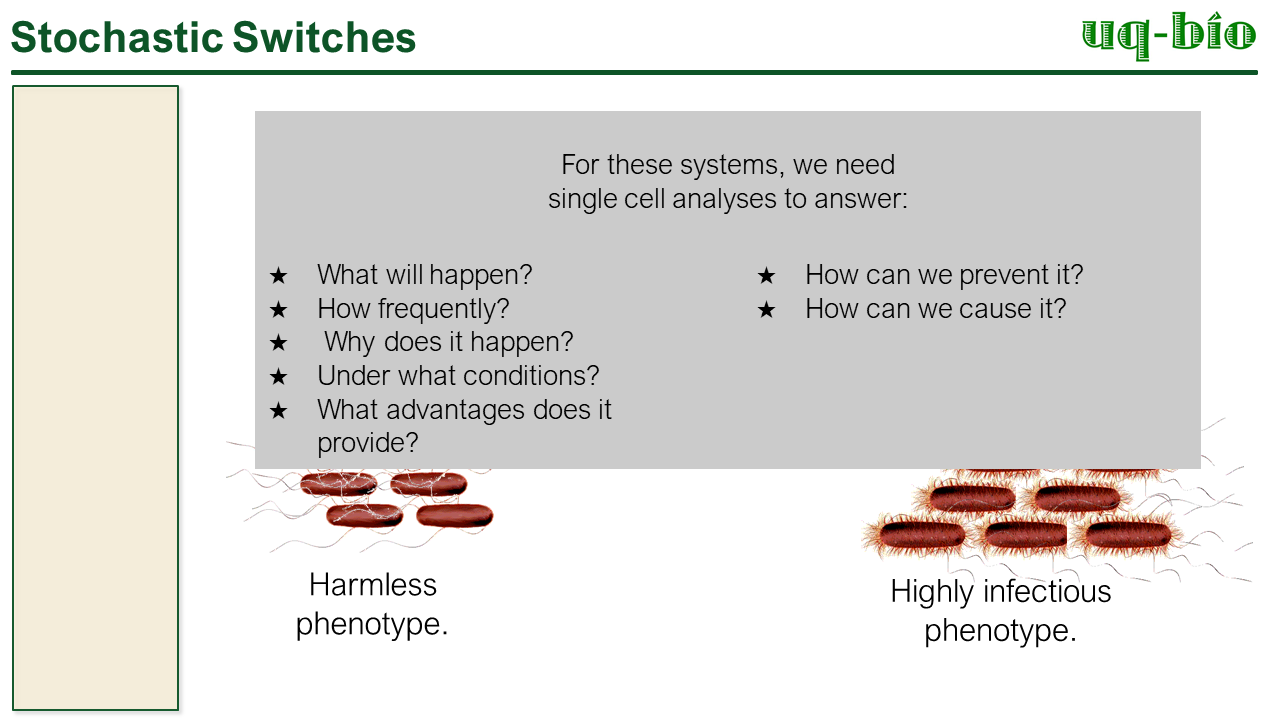

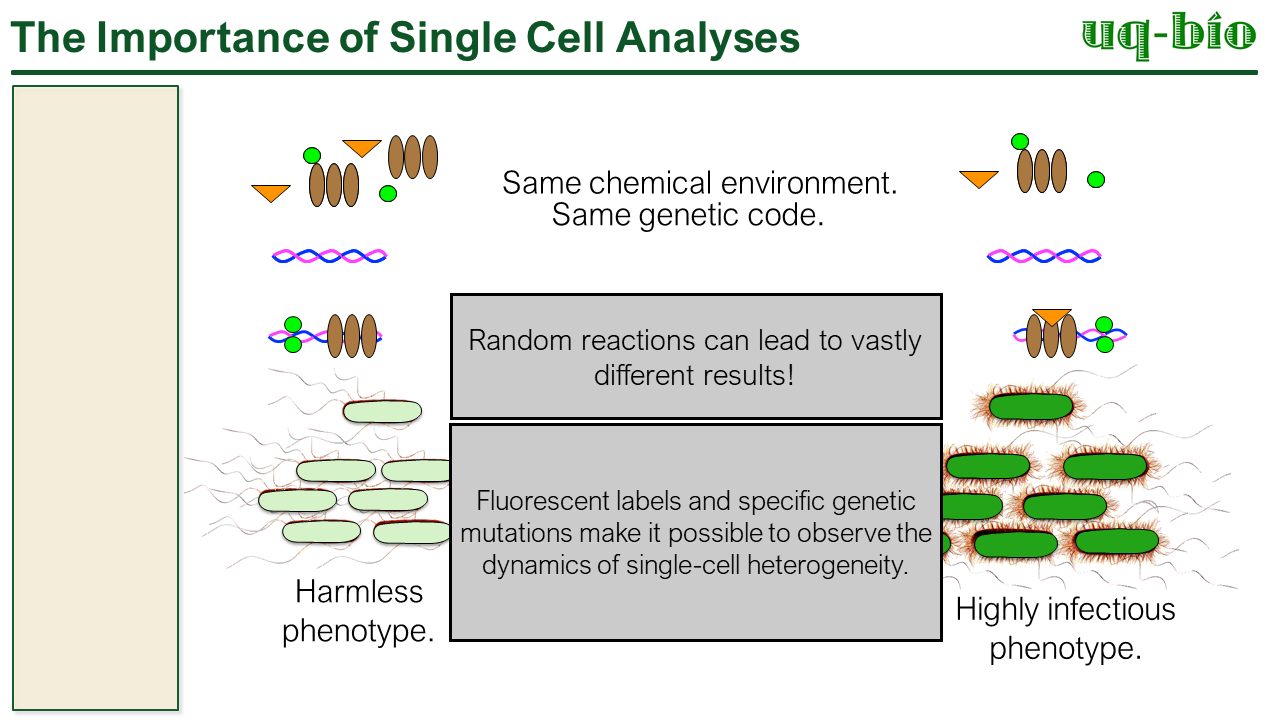

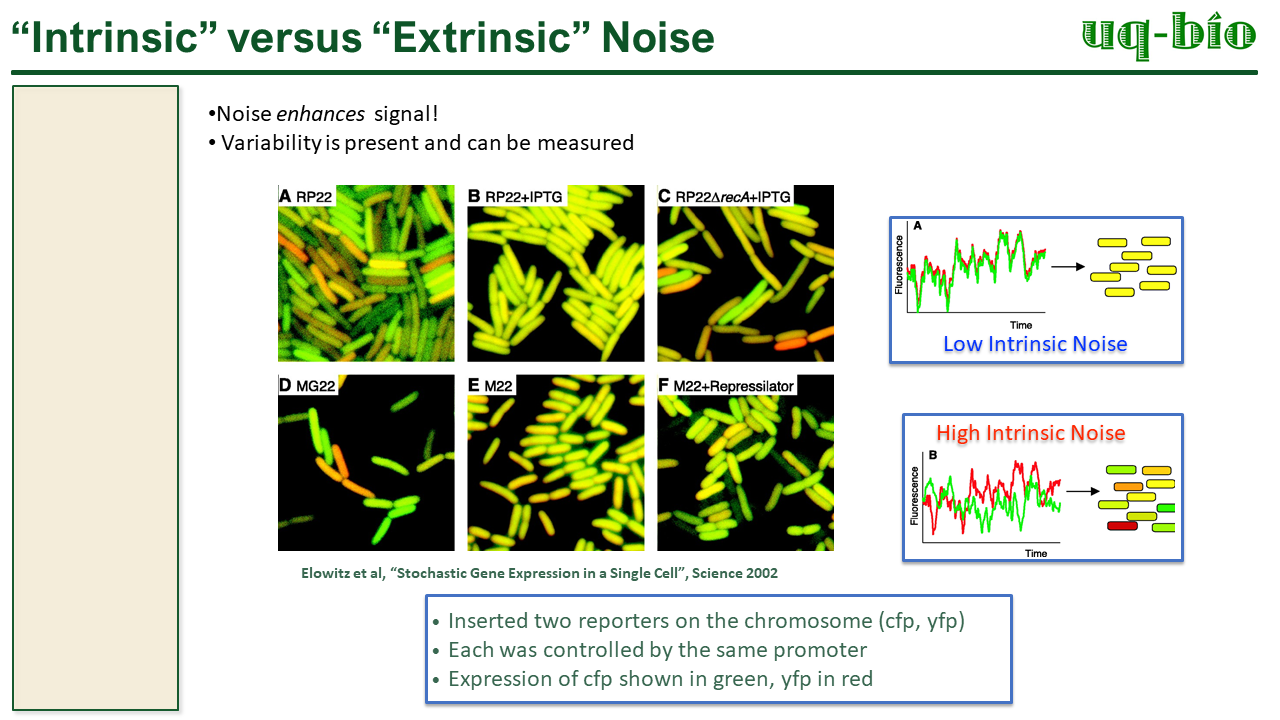

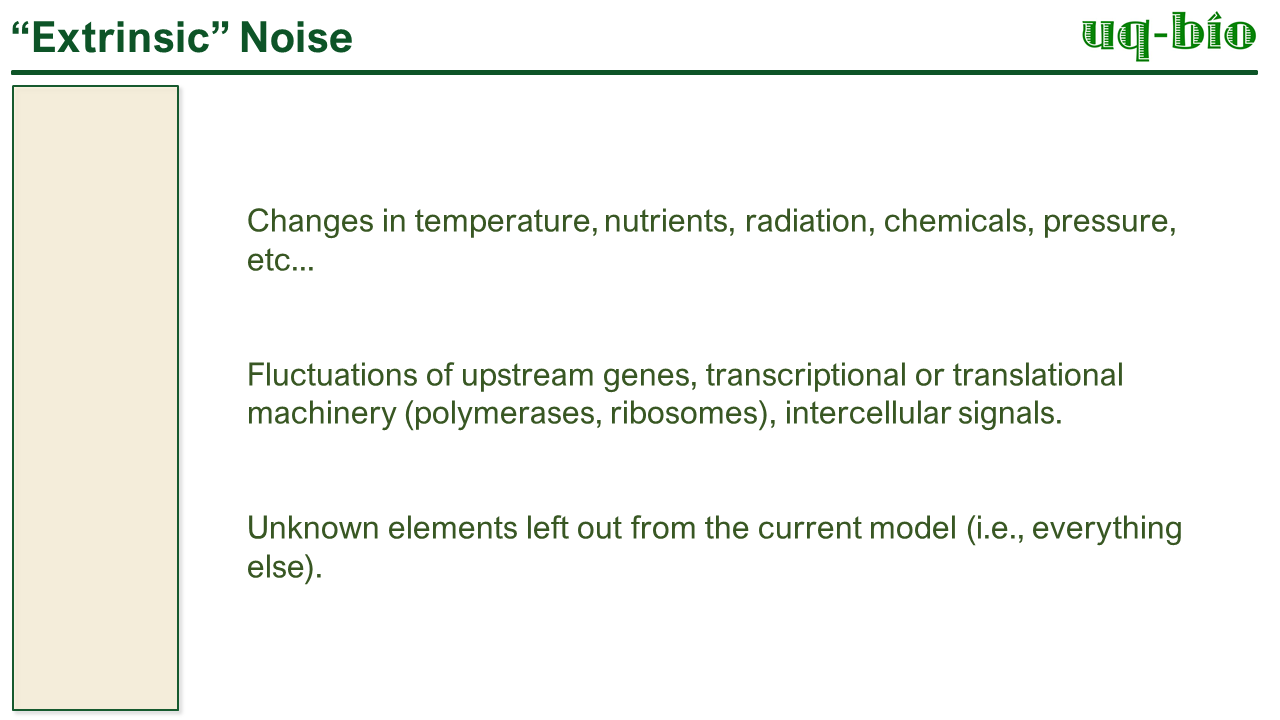

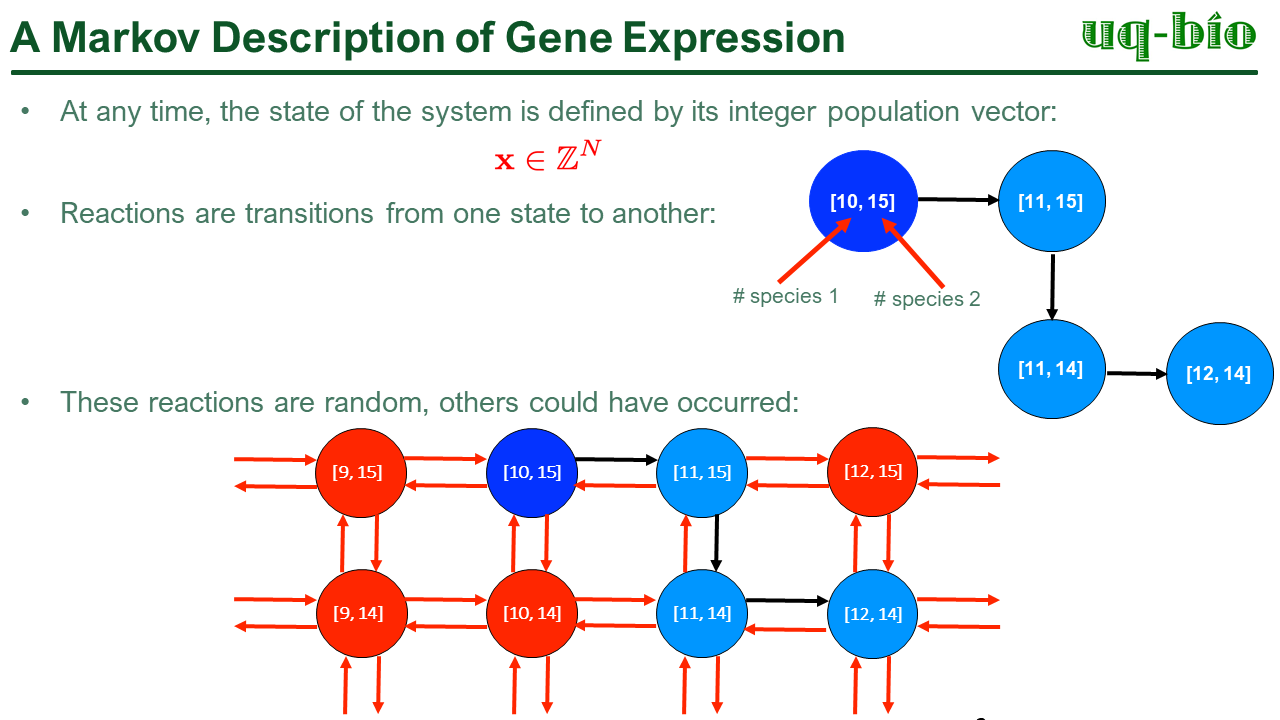

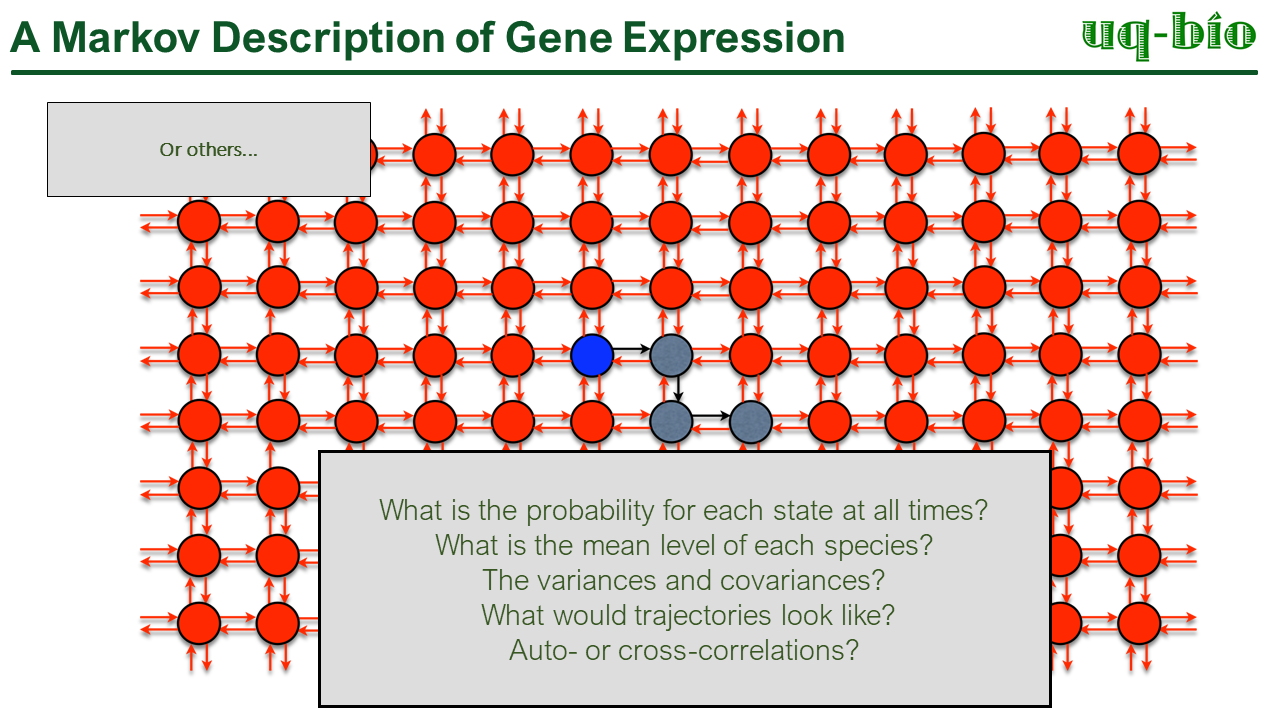

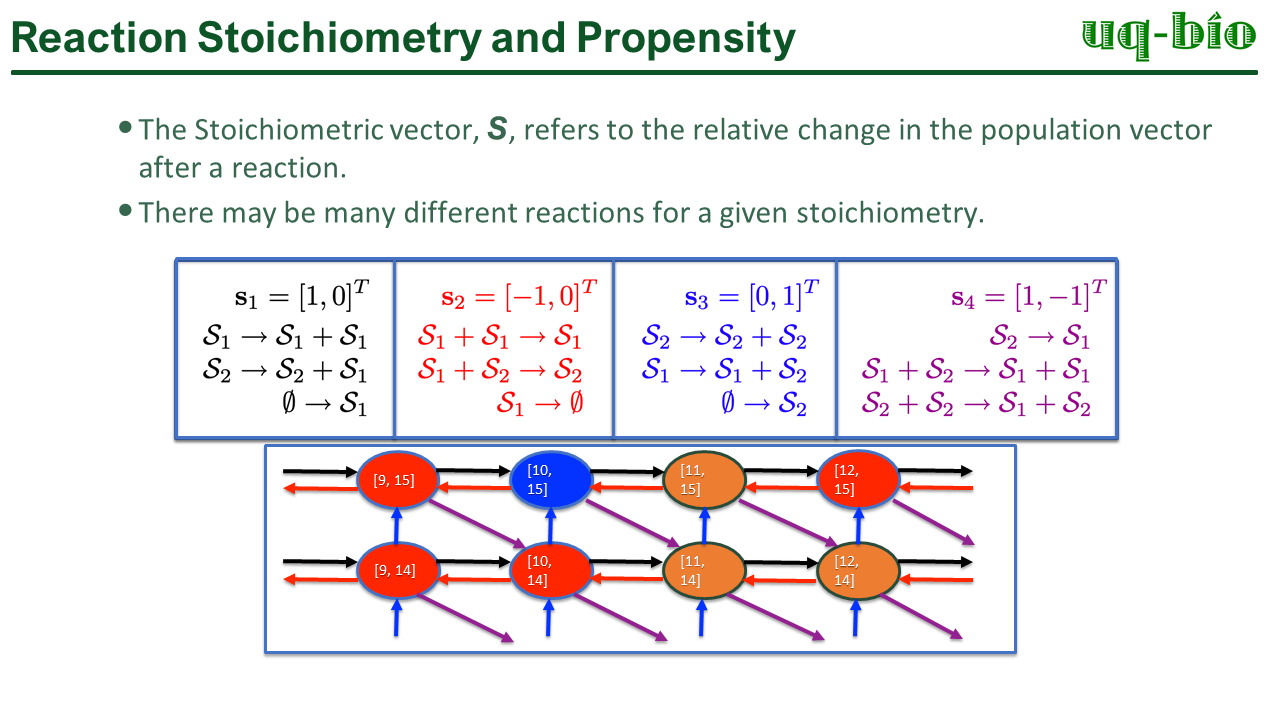

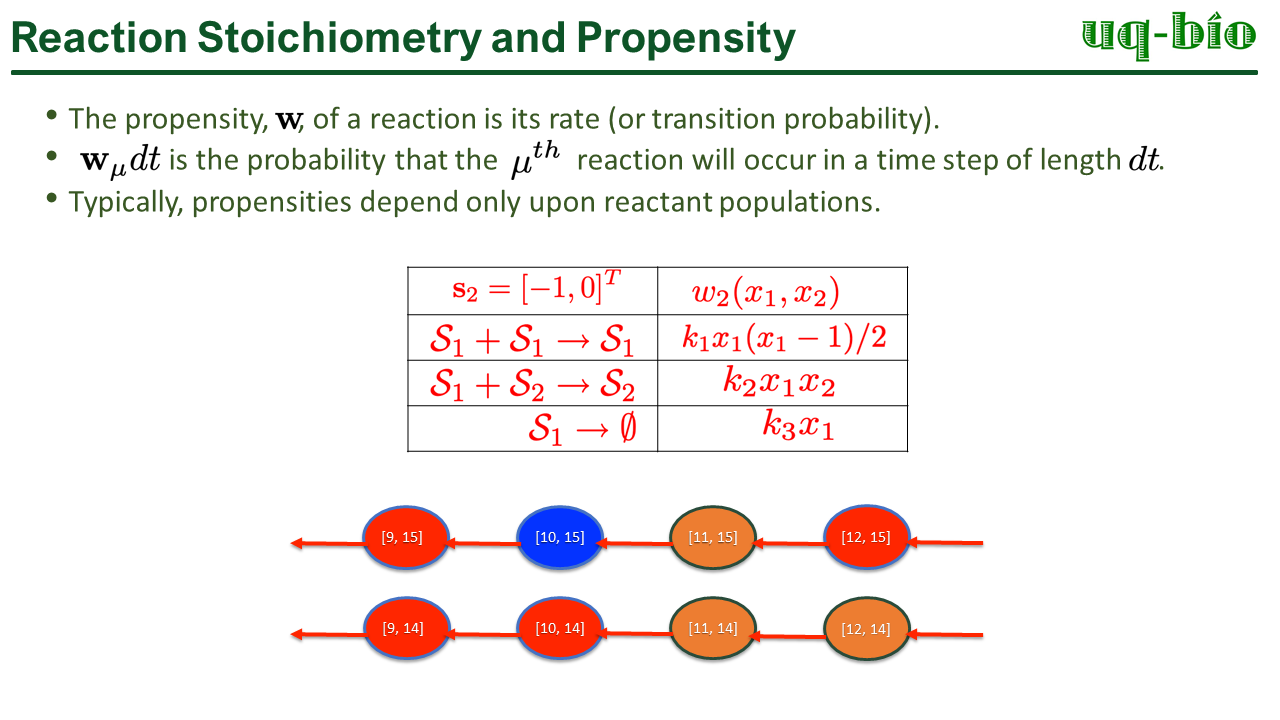

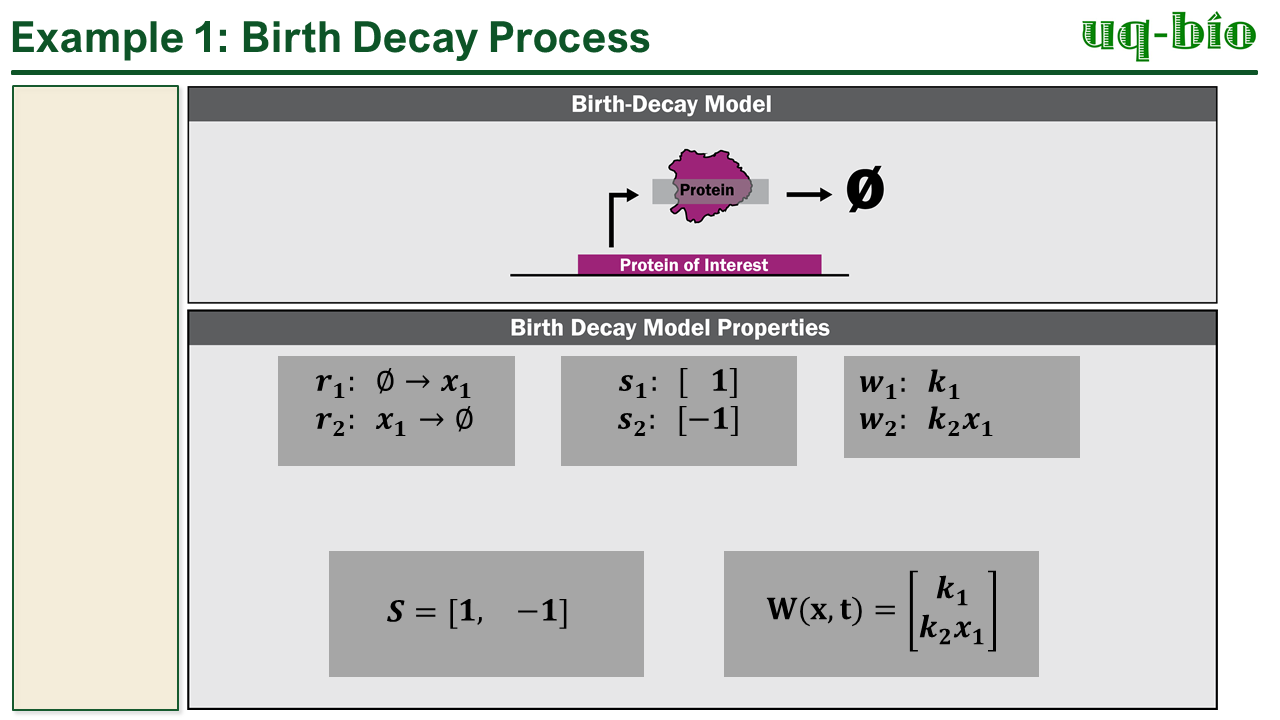

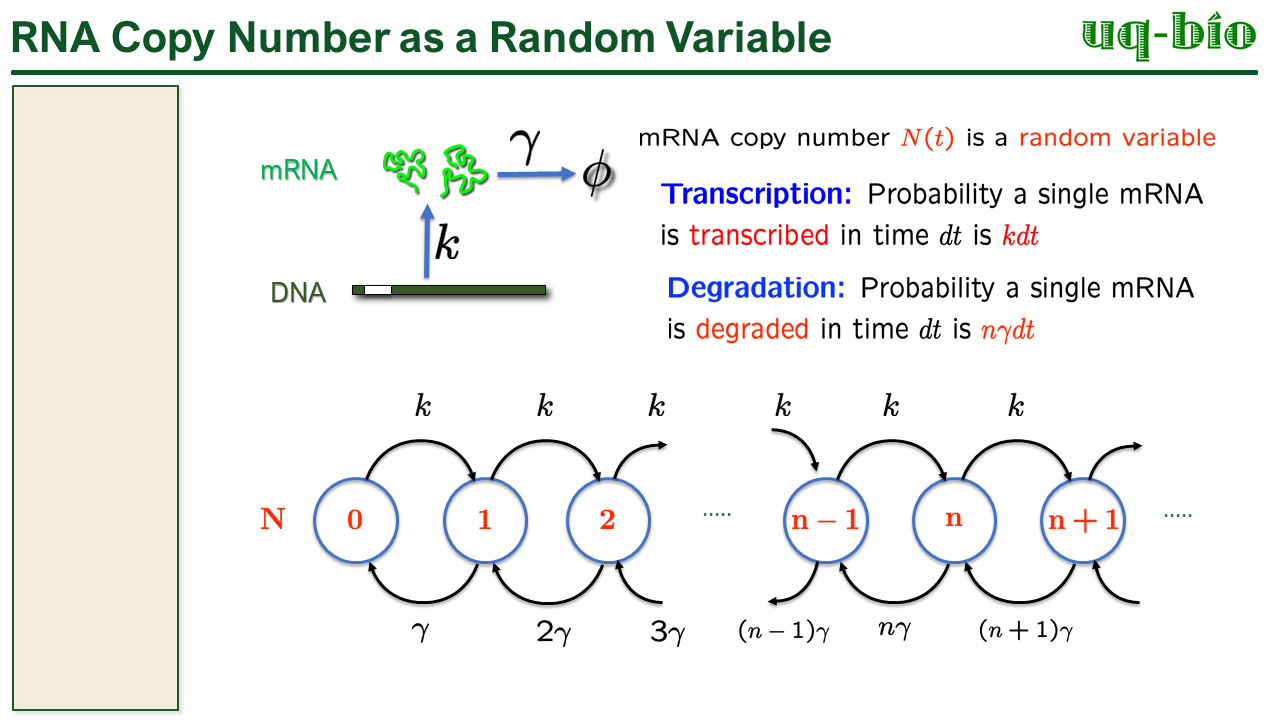

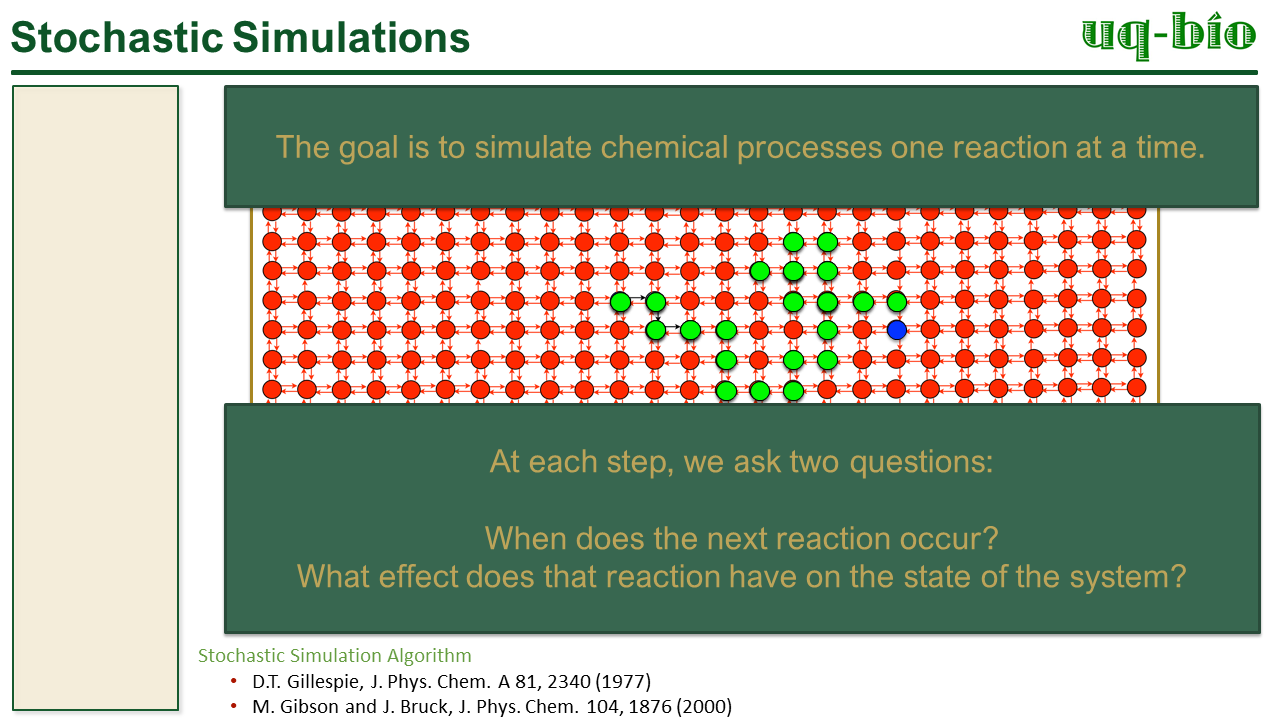

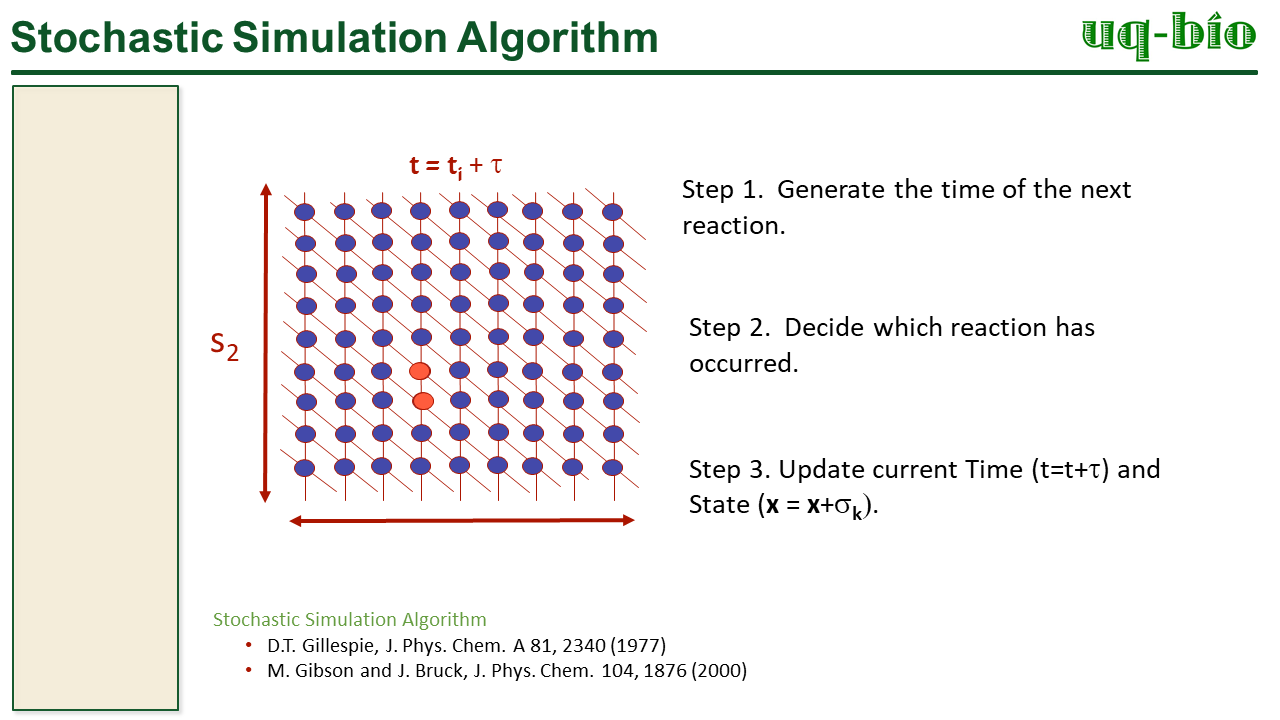

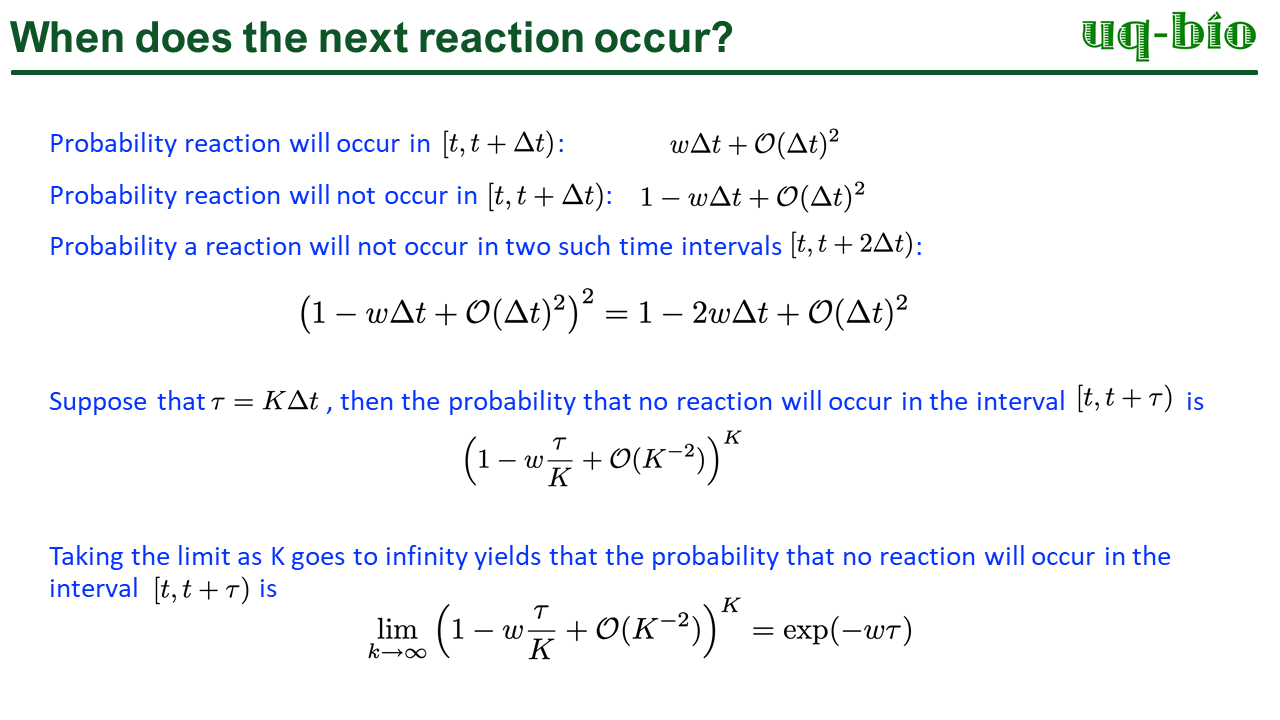

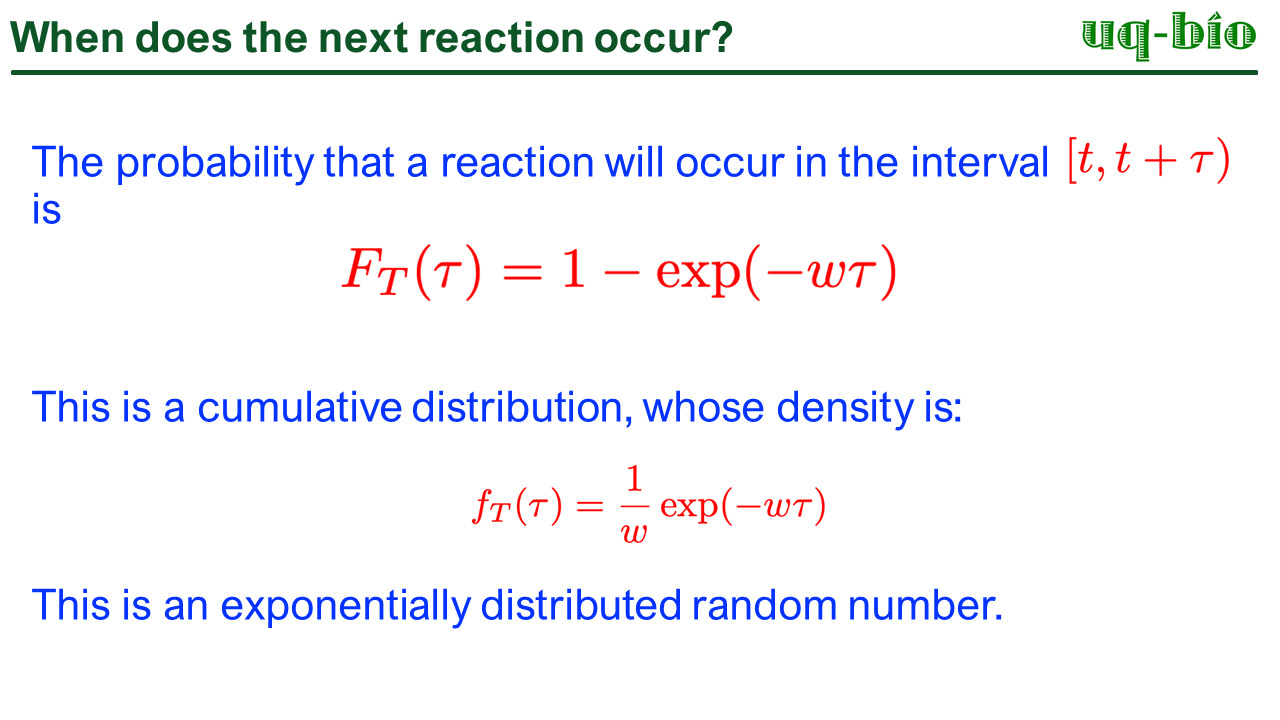

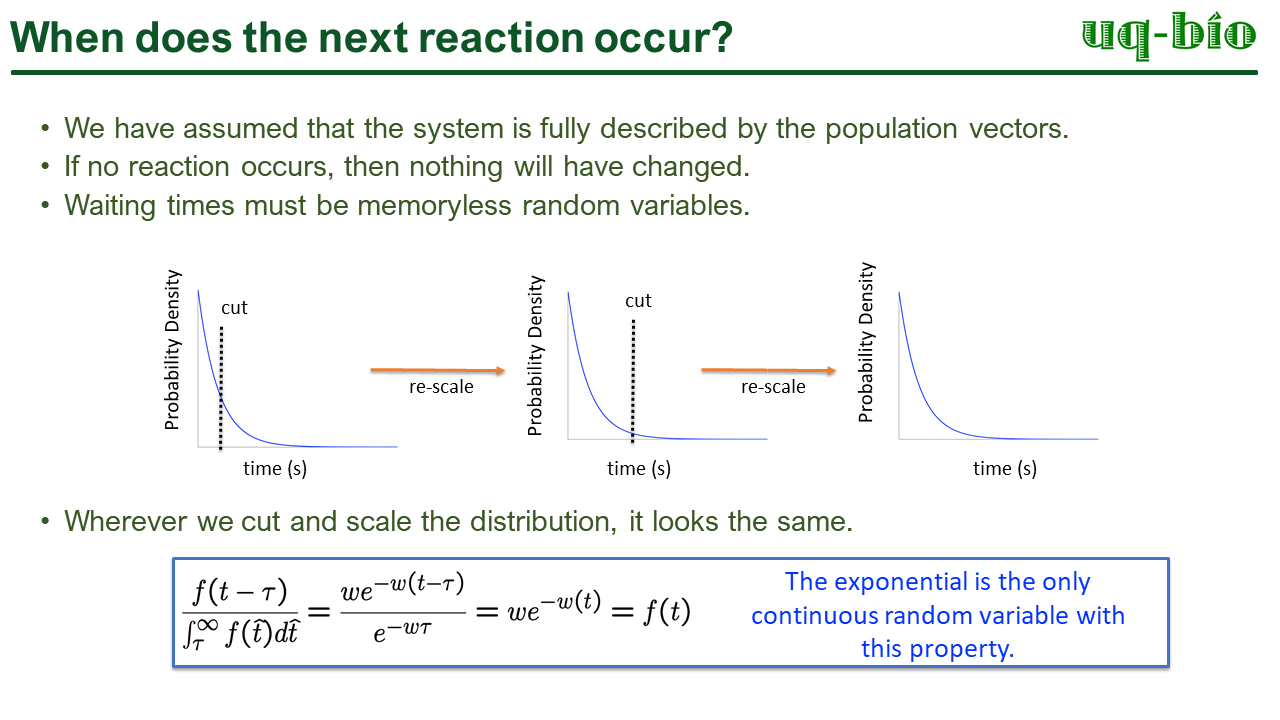

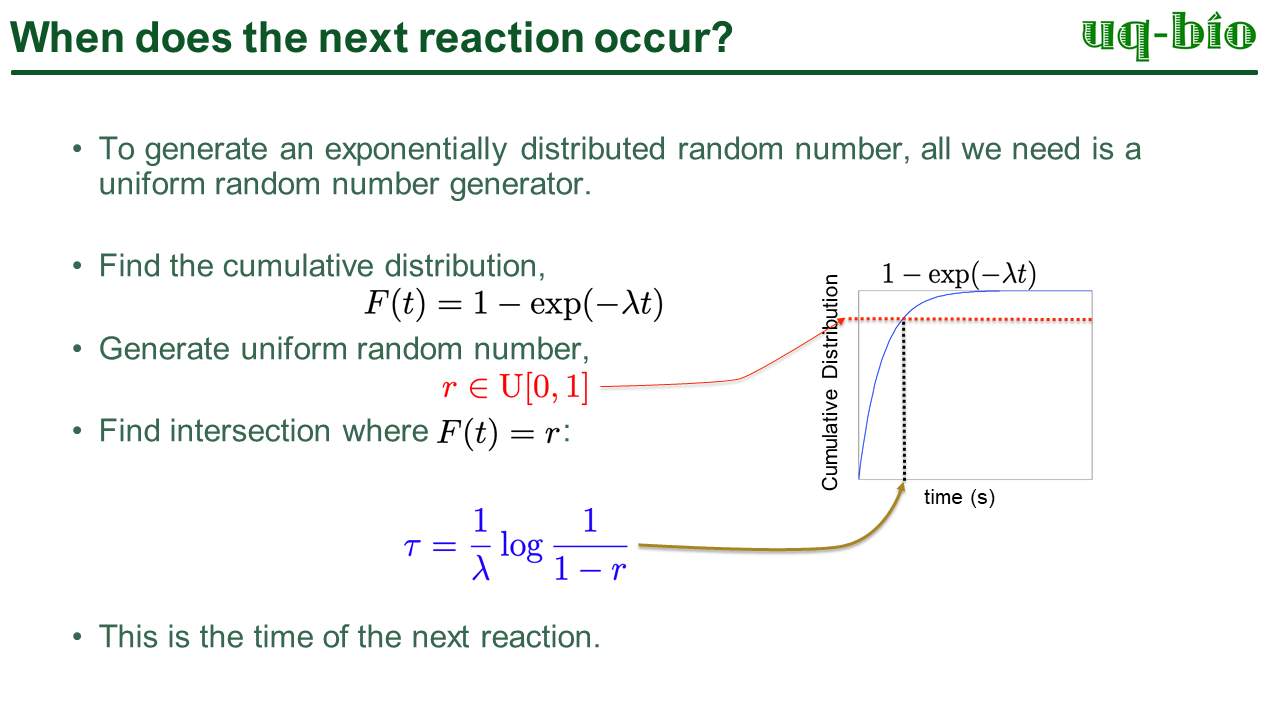

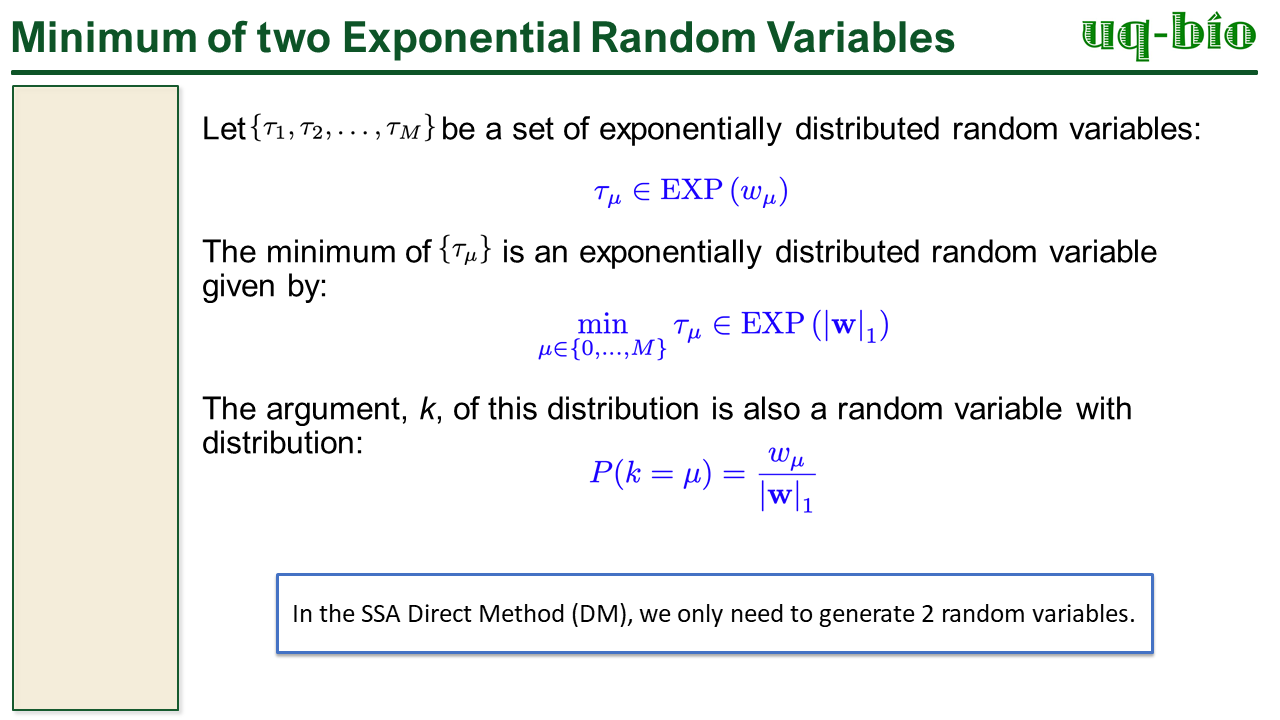

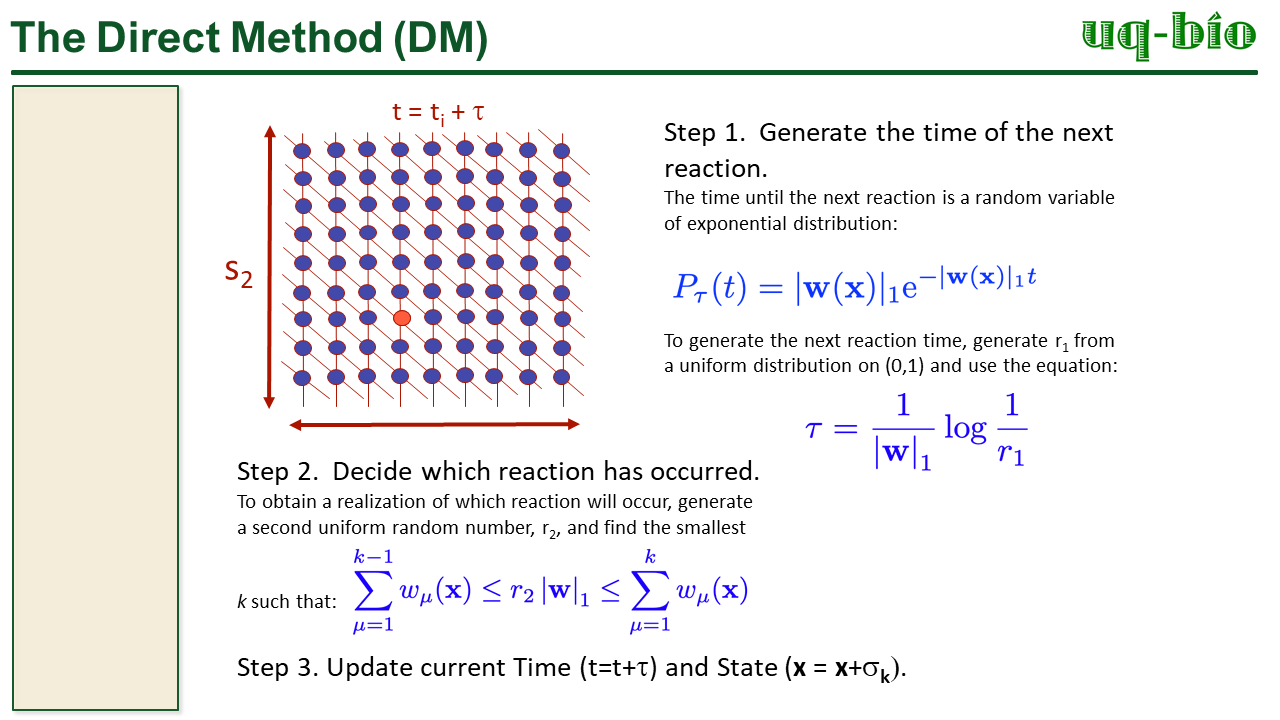

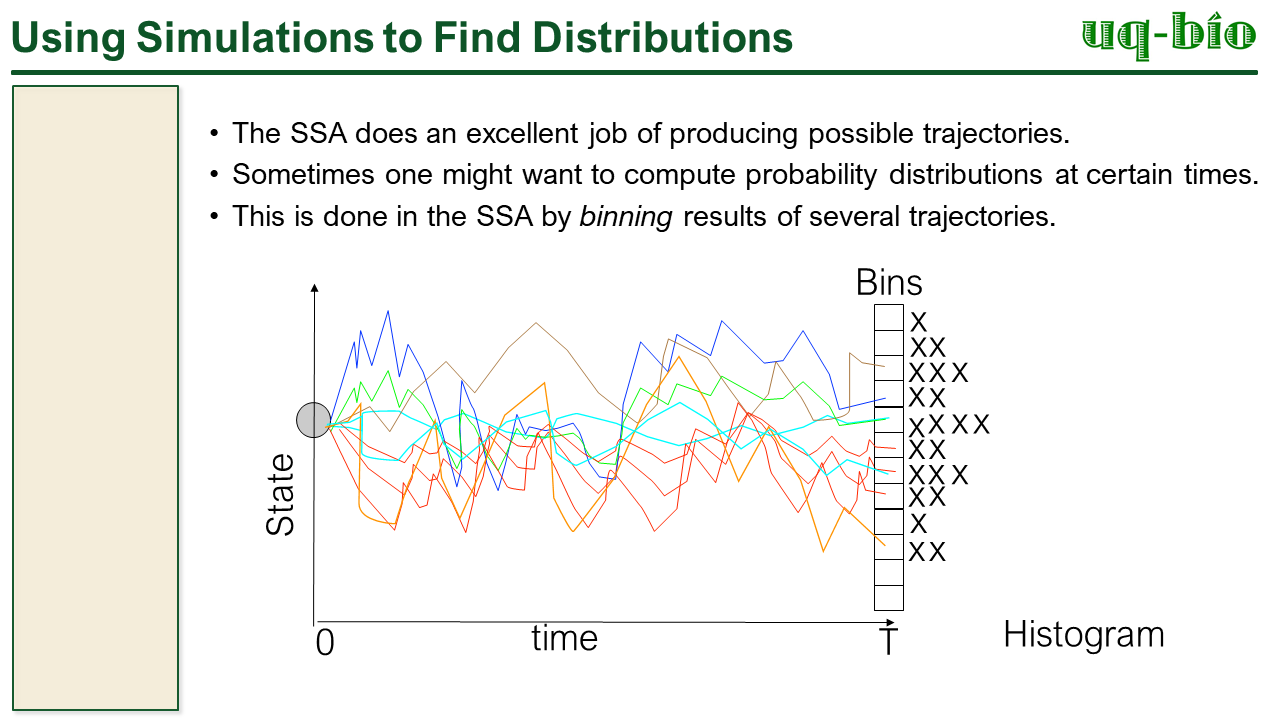

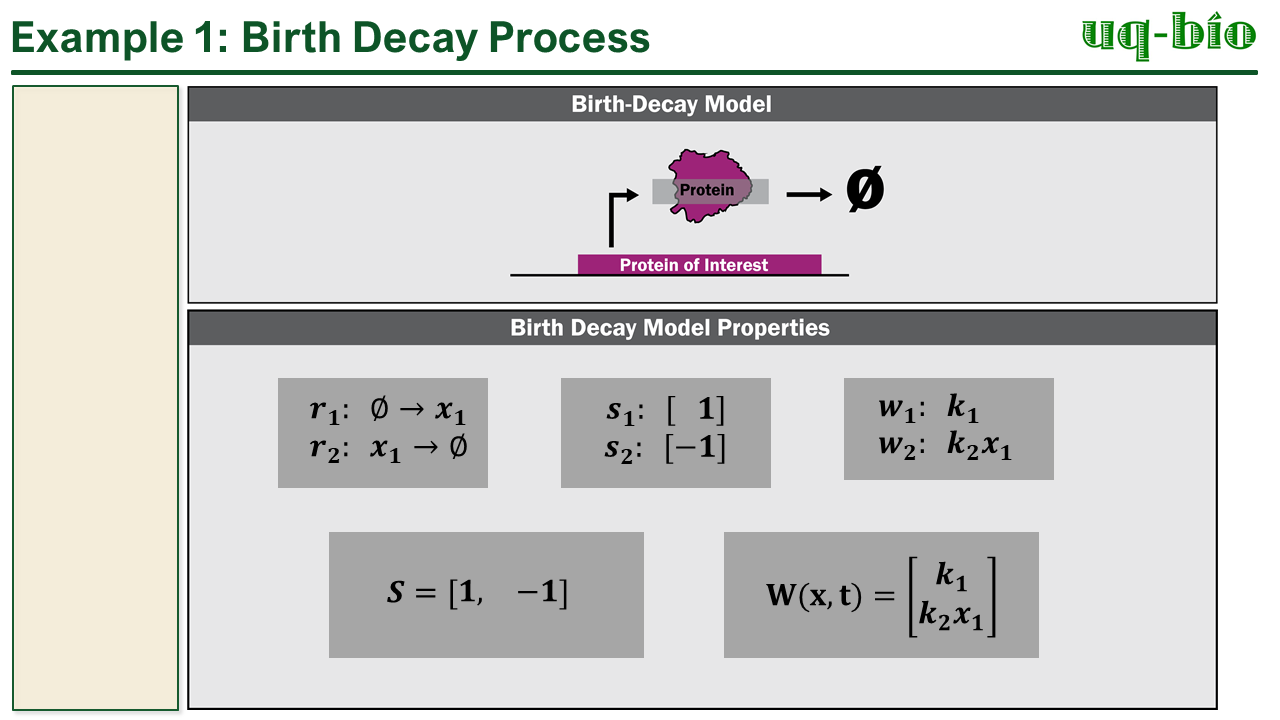

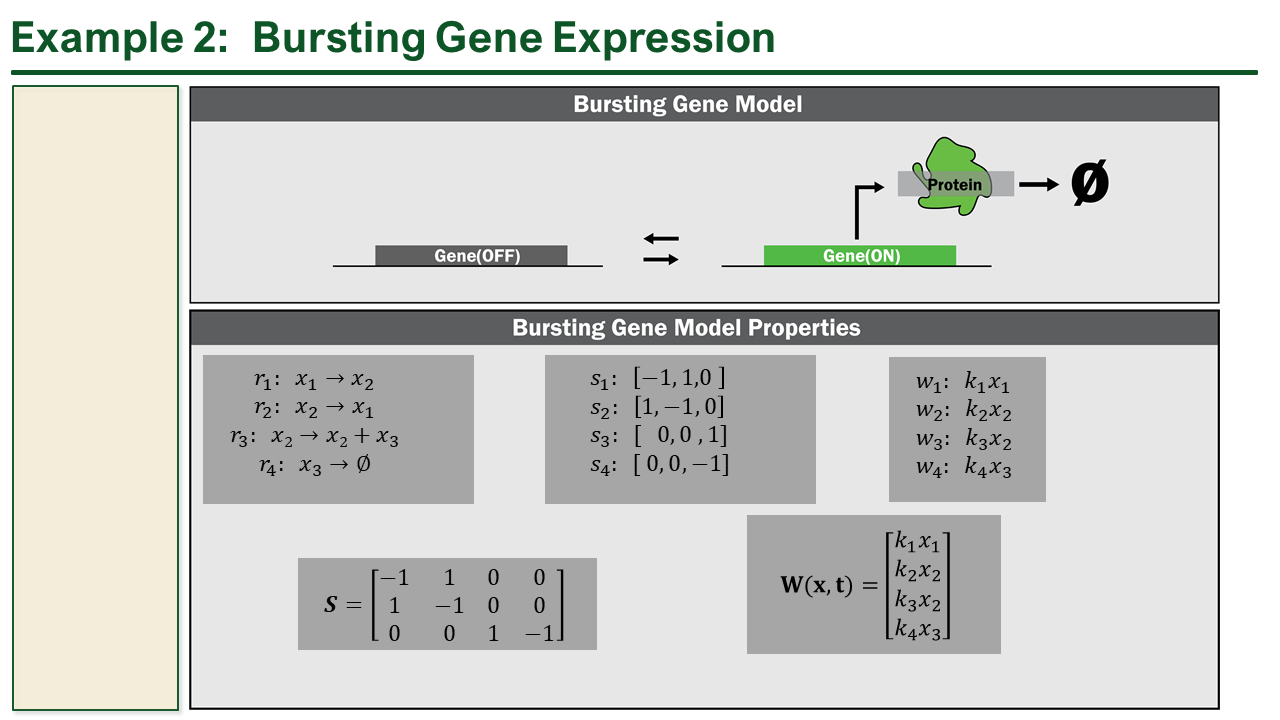

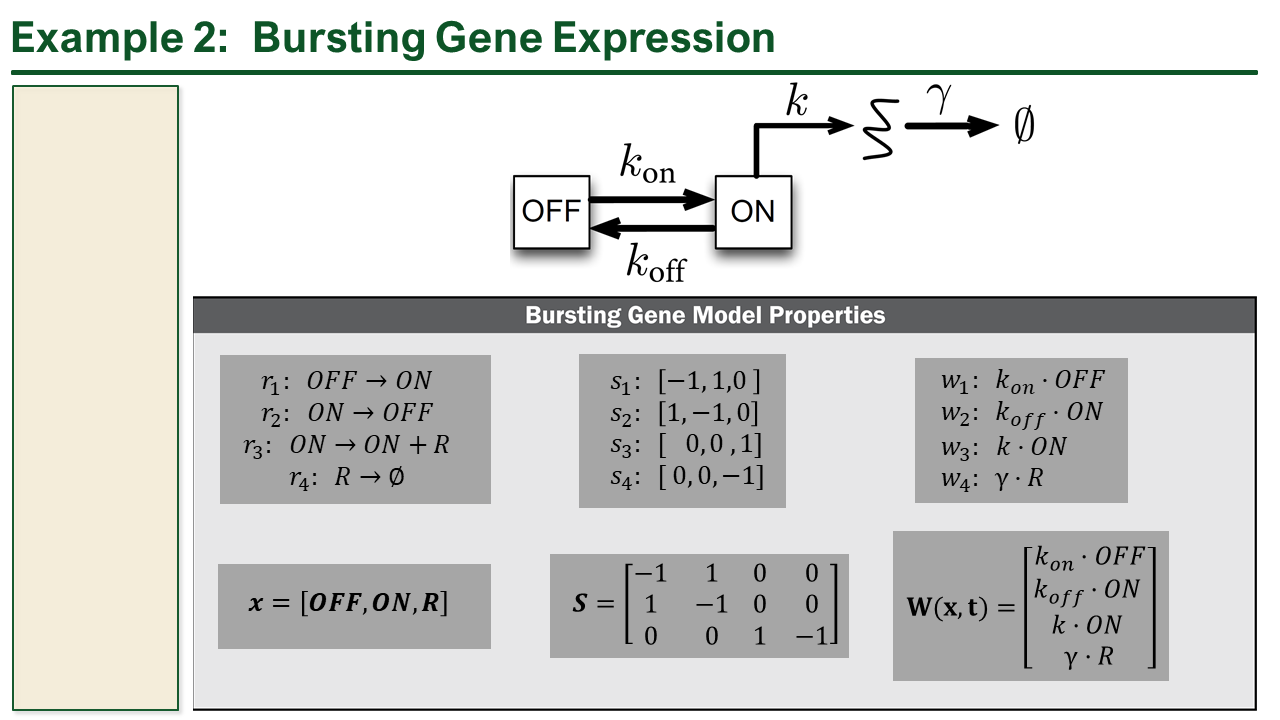

In [ ]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
from scipy.integrate import odeint

Define the parameters, stoichiometry matrix, and propensity functions for the model:

In [ ]:
# Vector of Times
t = np.linspace(0, 100, 101) 

# Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
Pars = np.array([0.2,0.5,10,0.1])
k_on,k_off,k_R,gamma = Pars

# Vector of Initial Conditions (OFF,ON,R)
X = np.array([1,0,0], dtype=int)   # OFF = X[0,0], ON = X[0,1], R = X[0,2]  

# Stoichiometry Matrix -- must be transposed (flipped) 
# Species:    OFF,ON,mRNA
S = np.array([[-1, 1, 0],     # Rxn 1: OFF --> ON  
              [1, -1, 0],     # Rxn 2: ON --> OFF
              [0, 0, 1],      # Rxn 3: ON --> ON + mRNA  (mRNA synthesis)
              [0, 0, -1]]).T  # Rxn 4: mRNA --> phi  (mRNA decay)

# Propensity Functions (anonymous function)
W = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0,0]
              [k_off*X[1]],           # Pars[1]*X[0,1]
              [k_R*X[1]],          # Pars[2]*X[0,1]
              [gamma*X[2]]]).T   # Pars[3]*X[0,2]

#W = lambda X: p(X)  # Anonymous function with propensities



**Questions:**

*   How should the above be modified for the birth/decay model? 
*   What would need to be done to add protein production and degradation to this model?









Given the state (X) and the propensity functions (p), what is the next reaction and when does it occur?



In [ ]:
# Function to randomly determine next time and next state using random number generation
# based on the current propensities (exponential waiting time)
def next_jump(W,X):
  current_propensities = W(X)
  total_reactions =current_propensities.shape[1]  # Get total number of reactions
  
  # Update time of next reaction (where tau = 1/w0*log(1/rand)
  time_next_rxn = -np.log(np.random.rand()) / np.sum(current_propensities)

  # Generate random number to select the new reaction to happen based on current state
  random_rate = np.random.rand() * np.sum(current_propensities)

  # Select the new reaction to happen based on current state
  cumulative_prop = np.cumsum(current_propensities)
  for i in range(total_reactions):
    if cumulative_prop[i] >= random_rate:
      rxn_id = i
      break
  return time_next_rxn,rxn_id  ##Return these back out


How does the time until the next reaction and the value to determine the next reaction vary over multiple runs?

Text(0, 0.5, 'Probability')

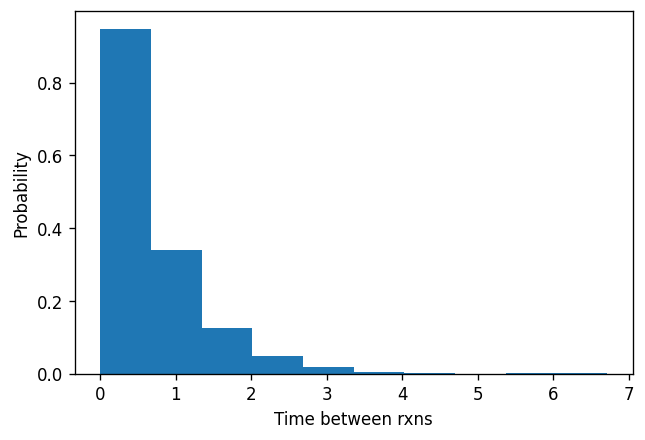

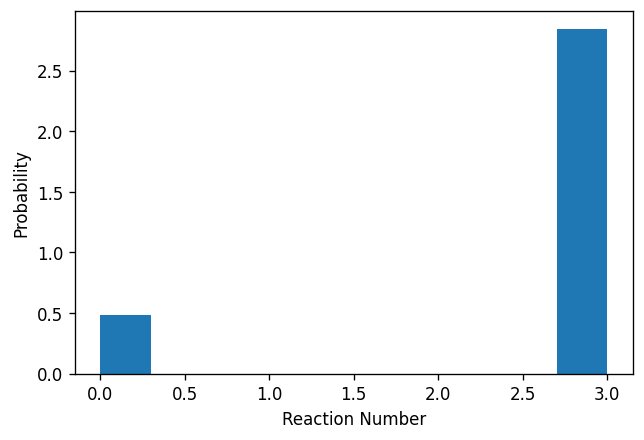

In [ ]:
# total number of runs
N = 2364  #@param {type:"slider", min:50, max:10000, step:1}

# Initialize output arrays for next time and next reaction
t_next_rxn = np.zeros(N,dtype=float);
next_rate = np.zeros(N,dtype=int);
X = np.array([1,0,12])   # OFF = X[0], ON = X[1], R = X[2]  

for i in range(0,N): 
  t_next_rxn[i],next_rate[i] = next_jump(W,X);  # Run function to get next time and next reaction  
  
plt.figure(dpi=120)
plt.hist(t_next_rxn,density=True)
plt.xlabel('Time between rxns')
plt.ylabel('Probability')
plt.figure(dpi=120)
plt.hist(next_rate,density=True)
plt.xlabel('Reaction Number')
plt.ylabel('Probability')


The Stochastic Simulation Algorithm:

In [ ]:
def SSA_traj(S, W, x0, time_vector):
    total_states = S.shape[0]     # Get total states (number of species)
    x = x0  # Set the state to initial state
    t = time_vector[0]  # Initial time - 1st time in time_vector
    tstop = time_vector[-1]  # Stop time - Last time in time_vector
    record_index = 0  # Initialize counter
    Nt = len(time_vector)  # Total number of time points
    traj_data = np.zeros((total_states, Nt)) # Preallocate for efficiency

    while t < tstop:  # While time is less than last time point
  
        time_next_rxn,rxn_id = next_jump(W,x)  # Run function to get next time and next reaction
        t += time_next_rxn

        while t >= time_vector[record_index]:  # If time passed the record vector, record the state
            traj_data[:, record_index] = x
            record_index += 1   # Update the counter
            if time_vector[record_index] == tstop:  # If counter has moved past the final time point, end and return the data
                traj_data[:, record_index] = x
                return traj_data

        x = x + S[:, rxn_id]  # Update the state based on last reaction




Run the SSA for one trajectory and plot the results:



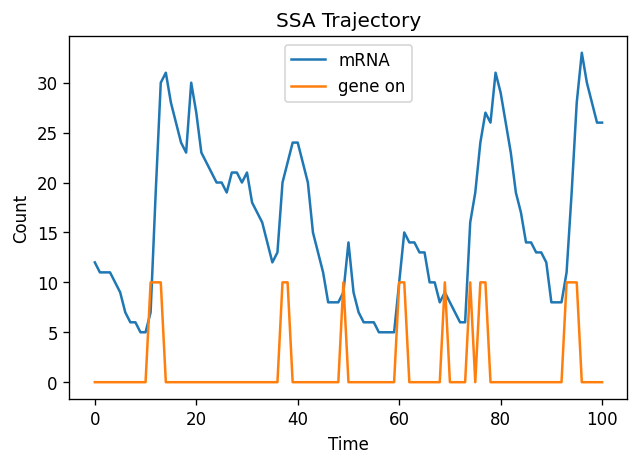

In [ ]:
# Run the SSA for a single trajectory
off, on, mRNA = SSA_traj(S, W, X, t)

# Plot the counts from the SSA
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on*10); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectory')
plt.legend(['mRNA', 'gene on'])


Interactive parameter trajectory and plot:

Text(0, 0.5, 'Count')

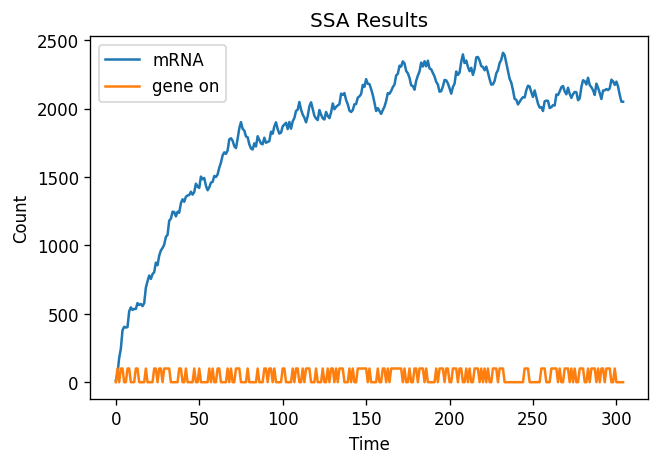

In [ ]:
tf =  790 #@param {type:"slider", min:100, max:10000, step:1}
tstep = 305 #@param {type:"slider", min:100, max:10000, step:1}
k_on = 0.71 #@param {type:"slider", min:0.01, max:100, step:0.1}
k_off = 0.91 #@param {type:"slider", min:0.01, max:100, step:0.1}
k_R = 47.81 #@param {type:"slider", min:0.01, max:1000, step:0.1}
gamma  = 0.01 #@param {type:"slider", min:0.01, max:1000, step:0.1}


W_2 = lambda X: np.array([[k_on*X[0]],  # Pars[0]*X[0,0]
              [k_off*X[1]],             # Pars[1]*X[0,1]
              [k_R*X[1]],               # Pars[2]*X[0,1]
              [gamma*X[2]]]).T          # Pars[3]*X[0,2]
t = np.linspace(0,tf,tstep)
off, on, mRNA = SSA_traj(S, W_2, X, t)
plt.figure(dpi=120)
plt.plot(mRNA);
plt.plot(on * 100);
plt.legend(['mRNA', 'gene on'])
plt.title('SSA Results')
plt.xlabel('Time')
plt.ylabel('Count')




To generate and plot multiple trajectories, use a loop structure:




Text(0.5, 0, 'Probability Estimate')

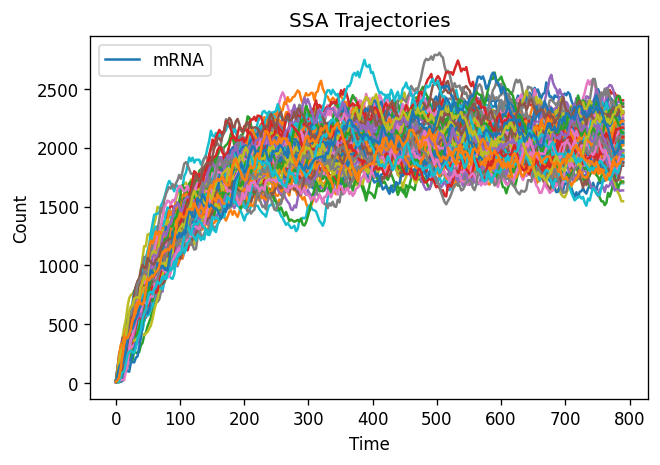

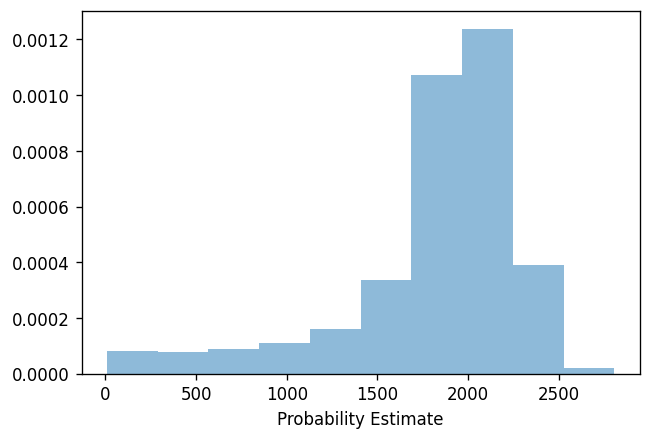

In [ ]:
import tqdm.notebook as tq #progress bar
# Run the SSA for a multiple trajectories
# Total trajectories to run
N_runs = 72   #@param {type:"slider", min:10, max:100, step:1}

# Initialize output array
counts = np.empty((X.shape[0], len(t), N_runs), dtype=int)

for i in tq.tqdm(range(0,N_runs)): #use the progress bar
  counts[:,:,i]= SSA_traj(S, W, X, t)

# Specify position of each species in outlet variable, counts
OFF = counts[0,:,:]
ON = counts[1,:,:]
R = counts[2,:,:]

# Plot the mRNA counts from the SSA
plt.figure(dpi=120)
plt.plot(t,R); 
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('SSA Trajectories')
plt.legend(['mRNA'])

# Let's take a look at the mRNA count distributions from all of SSA runs
plt.figure(dpi=120)
plt.hist(R.flatten(),bins=10,density=True,alpha=.5);
plt.xlabel('mRNA Count')
plt.xlabel('Probability Estimate')



Some analysis of the SSA results:

**Tasks:**

*   Calculate the standard deviation and variance in mRNA count from all SSA trajectories.
- Calculate the Fano factor, which is the ratio of the variance and the mean of the mRNA copy number. The Fano factor quantifies the deviation from Poisson statistics.






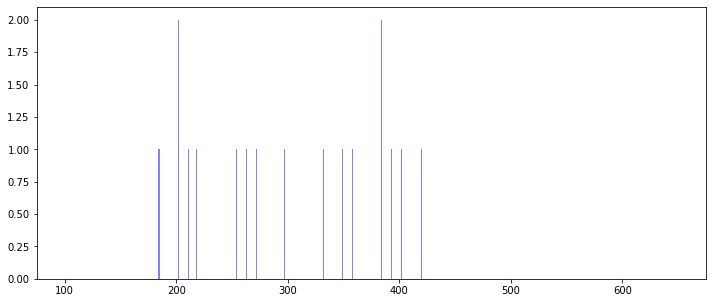

In [ ]:
# Determine the mean mRNA from all of SSA trajectories:
mean_mrna_ssa = np.mean(R,axis =1)

# To look at the mRNA distribution at different times, 
# we can plot a histogram for all SSA trajectories at a given time point.
# For this we use the function "hist" from matplotlib.
tstop = t[-1]  # Stop time
selected_time_point = 7 #@param {type:"slider", min:0, max:100, step:1}
plt.figure(figsize=(12,5))
plt.hist(R[selected_time_point,:], bins=max(R.max(0)), color ='blue',alpha=0.5)
plt.show()

# Determine the mRNA standard deviation and variance:




Compare the SSA results for mRNA Copy Number to the ODE (deterministic) solution:


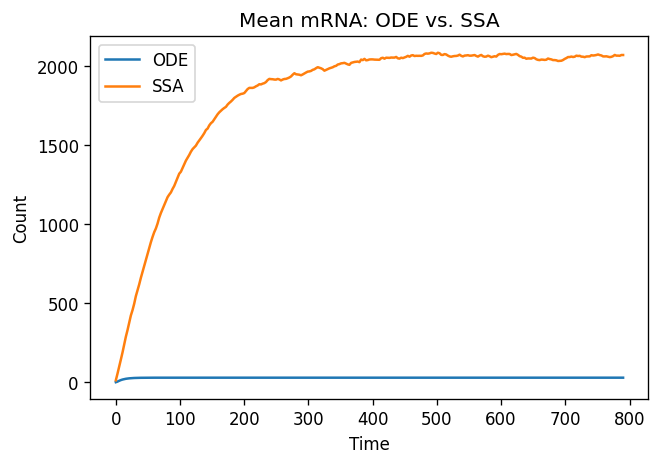

In [ ]:
#ODE model of 2 state bursting gene expression
def Gene_Model(X,t,pars = Pars):

    # Model Parameters (k_on, k_off, k_mrna, k_mrna_decay)
    k_on,k_off,k_R,gamma = Pars

#Set of ODEs that describe 2-state bursting gene expression with transcription
    dxdt = [k_off*X[1]-k_on*X[0], # OFF state ODE (State 1)
            k_on*X[0]-k_off*X[1], # ON state ODE (State 2)
            k_R*X[1]-gamma*X[2]] #in out of RNA
    return dxdt

# Solve the ODEs for the system
x0 = np.array([1,0,0])
ODE_soln = odeint(Gene_Model,x0,t,args=tuple([Pars,]))

mRNA_ode = ODE_soln[:,2]  # Specify the mRNA results from solving the ODE

# Plot the mean mRNA count from the SSAs compared to the ODE solution
plt.figure(dpi=120)
plt.plot(t,mRNA_ode); 
plt.plot(t,mean_mrna_ssa)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Mean mRNA: ODE vs. SSA')
plt.legend(['ODE','SSA'])


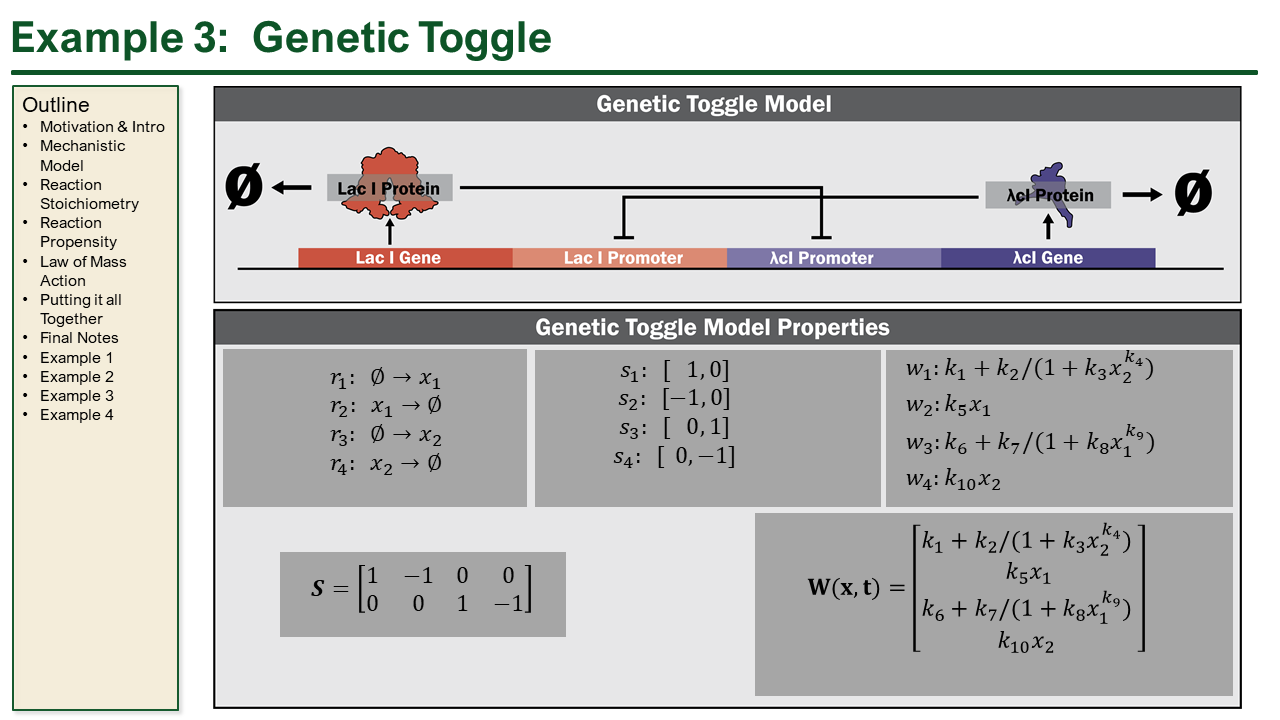

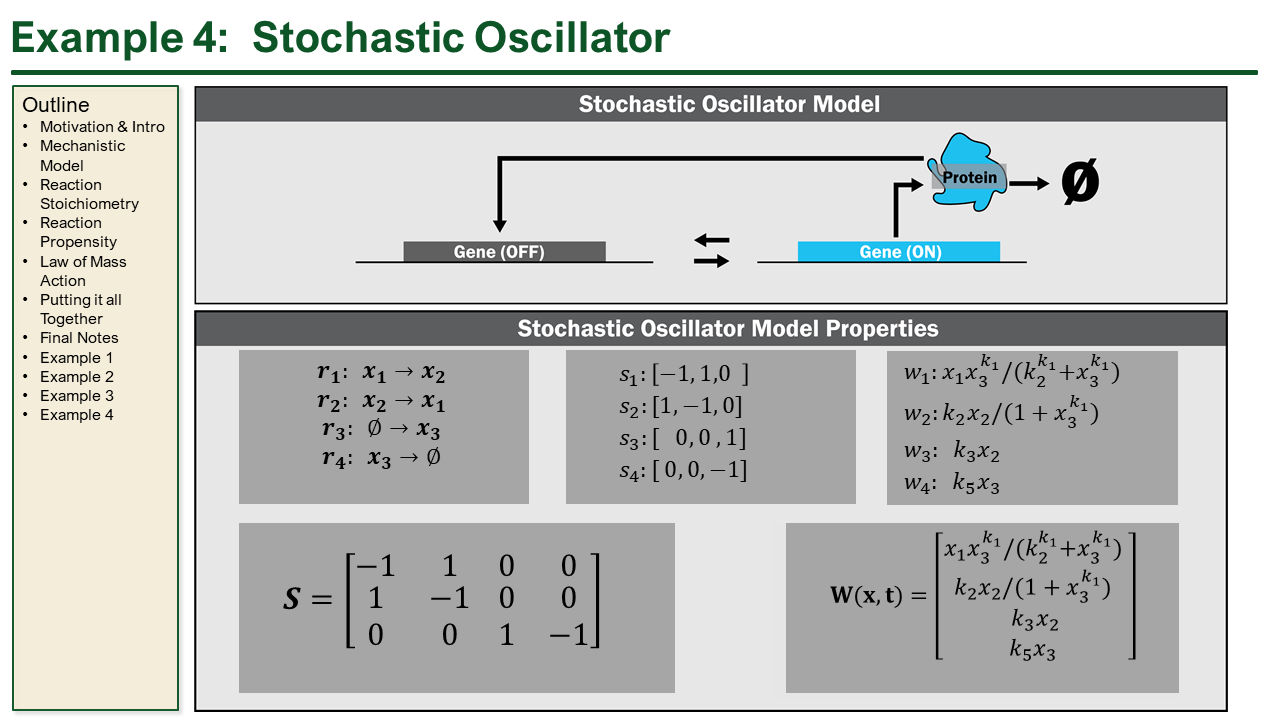


**Additional Exercises:**

- Modify the stoichiometry matrix and propensity functions for the other example models provided. 
    - Example 1: Birth/Decay Model
    - Example 3: Genetic Toggle
    - Example 4: Stochastic Oscillator
- Run the SSA for each of these example models. How do the results differ from the 2-state bursting gene model? 

